In [1]:
import torchvision
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
dataset=torchvision.datasets.CIFAR10(root=".\\",train=True, download=True)
test_dataset=torchvision.datasets.CIFAR10(root=".\\",train=False, download=True)

100%|██████████| 170M/170M [00:18<00:00, 9.02MB/s] 


Extracting .\cifar-10-python.tar.gz to .\
Files already downloaded and verified


In [3]:
print(dataset.classes)
labels=np.array(dataset.targets)
data=dataset.data

test_labels=np.array(test_dataset.targets)
test_data=test_dataset.data

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
selected_classes=[0,3,9]
selected_indices=[]
selected_test_indices=[]

for i in selected_classes:
    indices=np.where(labels==i)[0]
    indices2=np.where(test_labels==i)[0]
    selected_indices+=list(indices)
    selected_test_indices+=list(indices2)
selected_targets=labels[selected_indices]
selected_imgs=data[selected_indices]

Y_Test=test_labels[selected_test_indices]
X_Test=test_data[selected_test_indices]
X_Train, X_Val, Y_Train, Y_Val = train_test_split(selected_imgs,selected_targets,train_size=0.8,test_size=0.2, stratify=selected_targets)

# for i in [X_Train, X_Val, Y_Train, Y_Val]:
#     print(len(i))
#     print(np.shape(i))

In [5]:
class_mapping = {0:0, 3:1, 9:2}
Y_Train = np.array([class_mapping[label] for label in Y_Train])
Y_Val = np.array([class_mapping[label] for label in Y_Val])
Y_Test = np.array([class_mapping[label] for label in Y_Test])

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.img_labels = labels
        self.imgs = data
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
custom_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
train_data = CustomImageDataset(X_Train,Y_Train,transform=custom_transform)
val_data = CustomImageDataset(X_Val,Y_Val,transform=custom_transform)
test_data = CustomImageDataset(X_Test,Y_Test,transform=custom_transform)

In [9]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

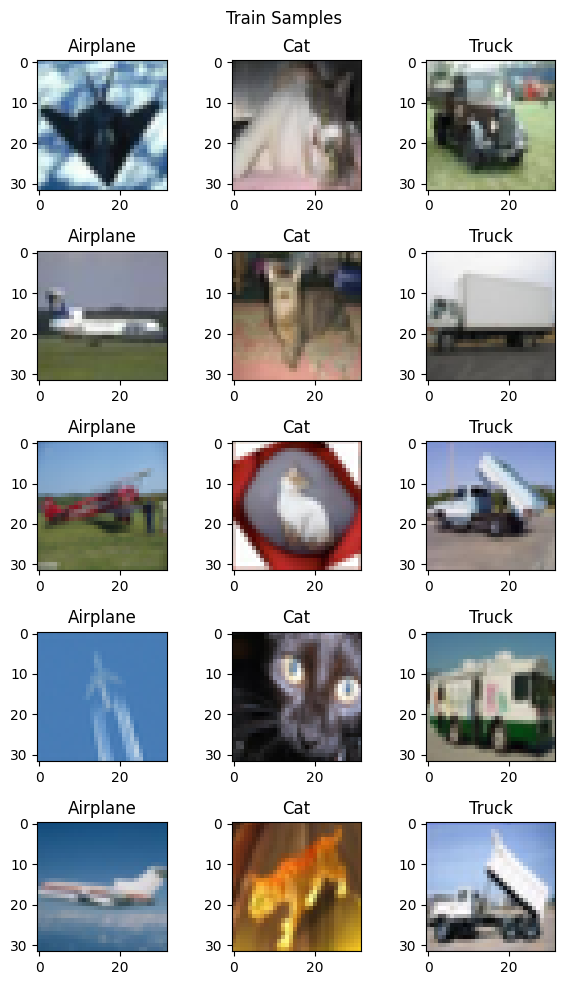

In [10]:
airplane=np.where(Y_Train==0)[0]
cat=np.where(Y_Train==1)[0]
truck=np.where(Y_Train==2)[0]

plt.figure(figsize=(6,10))
for i in range(5):
    for j in range(3):
        plt.subplot(5,3,3*i+j+1)
        if j==0:
            plt.imshow(X_Train[airplane[i]])
            plt.title("Airplane")
        if j==1:
            plt.imshow(X_Train[cat[i]])
            plt.title("Cat")
        if j==2:
            plt.imshow(X_Train[truck[i]])
            plt.title("Truck")
        plt.grid(False)
plt.suptitle("Train Samples")
plt.tight_layout()
plt.show()

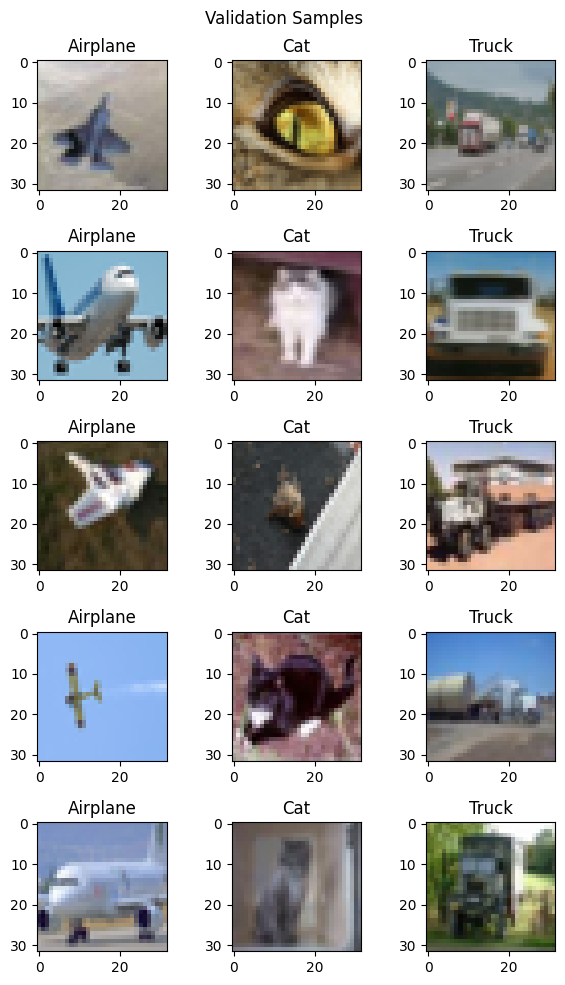

In [11]:
airplane=np.where(Y_Val==0)[0]
cat=np.where(Y_Val==1)[0]
truck=np.where(Y_Val==2)[0]

plt.figure(figsize=(6,10))
for i in range(5):
    for j in range(3):
        plt.subplot(5,3,3*i+j+1)
        if j==0:
            plt.imshow(X_Val[airplane[i]])
            plt.title("Airplane")
        if j==1:
            plt.imshow(X_Val[cat[i]])
            plt.title("Cat")
        if j==2:
            plt.imshow(X_Val[truck[i]])
            plt.title("Truck")
        plt.grid(False)
plt.suptitle("Validation Samples")
plt.tight_layout()
plt.show()

In [12]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,stride=1,padding=1,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=2)
        self.conv2 = nn.Conv2d(16,32,stride=2,padding=0,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=3,stride=3)
        self.fc1 = nn.Linear(32*2*2,16)
        self.fc2 = nn.Linear(16,3)

    def forward(self, img):
        # print(F.relu(self.conv1(img)).shape)
        pool1_output = self.pool1(F.relu(self.conv1(img)))
        # print(pool1_output.shape)
        pool2_output = self.pool2(F.relu(self.conv2(pool1_output)))
        # print(pool2_output.shape)
        flatten_output = torch.flatten(pool2_output, 1)
        # print(flatten_output.shape)
        multi_layer1_output = F.relu(self.fc1(flatten_output))
        # print(multi_layer1_output.shape)
        # print(self.fc2(multi_layer1_output).shape)
        return self.fc2(multi_layer1_output)      #Classisfication head layer

In [13]:
cnn_model = CNN_Model()
import os
if not os.path.exists("cnn_model.pth"):
    optimizer=optim.Adam(cnn_model.parameters(), lr=1e-3)
    criterion=nn.CrossEntropyLoss()

    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]

    for j in range(15):
        cnn_model.train()
        epoch_loss_training=0
        correct_classified=0

        for i in train_dataloader:
            imgs, labels=i
            labels=labels.long()
            # print(labels.shape)
            optimizer.zero_grad()
            
            predictions = cnn_model(imgs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            epoch_loss_training+=loss.item()

            temp, predicted_classes_for_batch = torch.max(predictions, 1)
            for k in range(len(predicted_classes_for_batch)):
                if predicted_classes_for_batch[k]==labels[k]:
                    correct_classified+=1

        train_loss.append(epoch_loss_training/len(train_dataloader))
        train_accuracy.append(correct_classified/len(train_dataloader))

        cnn_model.eval()
        epoch_loss_val=0
        correct_classified_val=0

        for i in val_dataloader:
            imgs, labels=i
            labels=labels.long()
            predictions = cnn_model(imgs)
            loss = criterion(predictions, labels)
            epoch_loss_val += loss.item()
            
            temp, predicted_classes_for_batch = torch.max(predictions, 1)
            for k in range(len(predicted_classes_for_batch)):
                if predicted_classes_for_batch[k]==labels[k]:
                    correct_classified_val+=1

        val_loss.append(epoch_loss_val/len(val_dataloader))
        val_accuracy.append(correct_classified_val/len(val_dataloader))

        print(f"Epoch : {j+1}")
        print(f"Train Loss : {train_loss[-1]}")
        print(f"Train Accuracy : {train_accuracy[-1]}")
        print(f"Val Loss : {val_loss[-1]}")
        print(f"Val Accuracy : {val_accuracy[-1]}\n")

In [14]:
import os
if not os.path.exists("cnn_model.pth"):
    torch.save(cnn_model.state_dict(),"cnn_model.pth")

In [15]:
import os
if not os.path.exists("cnn_model.pth"):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.plot(range(1,16),train_loss,label='Training Losses')
    plt.plot(range(1,16),val_loss,label='Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
plt.show()

In [16]:
import os
if not os.path.exists("cnn_model.pth"):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,2)
    plt.plot(range(1,16),train_accuracy,label='Training Accuracy')
    plt.plot(range(1,16),val_accuracy,label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [17]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [18]:
cnn_model.load_state_dict(torch.load("cnn_model.pth",weights_only=True))
cnn_model.eval()
predictions=[]
label_list=[]
pred_train=[]
pred_val=[]

for i in test_dataloader:
    imgs, labels=i
    imgs = imgs
    labels = labels.long()
    
    predict = cnn_model(imgs)
    temp,predicted_classes = torch.max(predict, 1)
    
    predictions.extend(predicted_classes.numpy())
    label_list.extend(labels.numpy())

for i in train_dataloader:
    imgs, labels=i
    imgs = imgs
    labels = labels.long()
    
    predict = cnn_model(imgs)
    temp,predicted_classes = torch.max(predict,1)
    
    pred_train.extend(predicted_classes.numpy())

for i in val_dataloader:
    imgs, labels=i
    imgs = imgs
    labels = labels.long()
    
    predict = cnn_model(imgs)
    temp,predicted_classes = torch.max(predict,1)
    
    pred_val.extend(predicted_classes.numpy())

In [19]:
test_accuracy = accuracy_score(label_list,predictions)
test_f1_score = f1_score(label_list,predictions,average='weighted')

print(f"Test Accuracy : {test_accuracy}")
print(f"Test F1-Score : {test_f1_score}")

Test Accuracy : 0.8603333333333333
Test F1-Score : 0.8605952394218805


In [20]:
from sklearn import metrics

<Figure size 600x600 with 0 Axes>

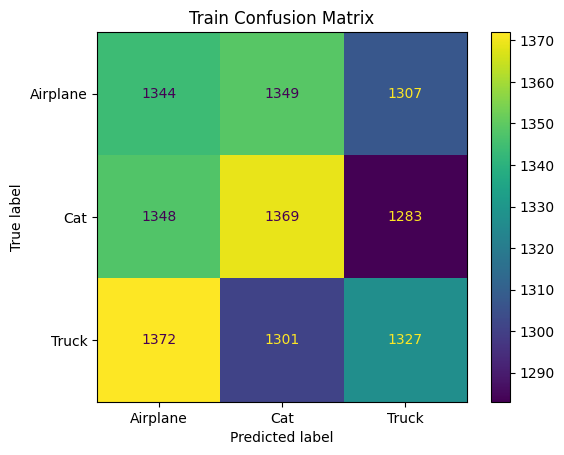

In [21]:
confusion_matrix = metrics.confusion_matrix(Y_Train,pred_train)
plt.figure(figsize=(6,6))
plot_matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Airplane","Cat","Truck"])
plot_matrix.plot()
plt.title("Train Confusion Matrix")
plt.show()

<Figure size 600x600 with 0 Axes>

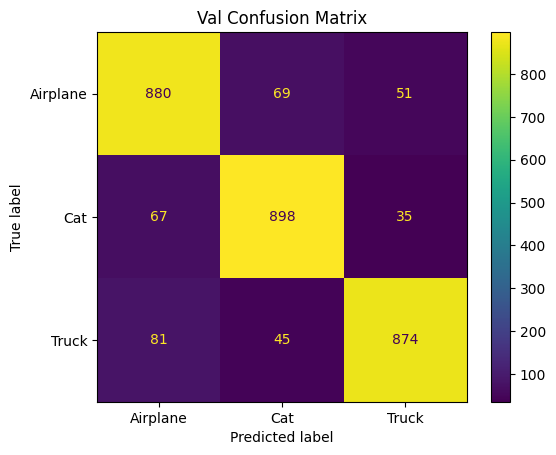

In [22]:
confusion_matrix = metrics.confusion_matrix(Y_Val,pred_val)
plt.figure(figsize=(6,6))
plot_matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Airplane","Cat","Truck"])
plot_matrix.plot()
plt.title("Val Confusion Matrix")
plt.show()

<Figure size 600x600 with 0 Axes>

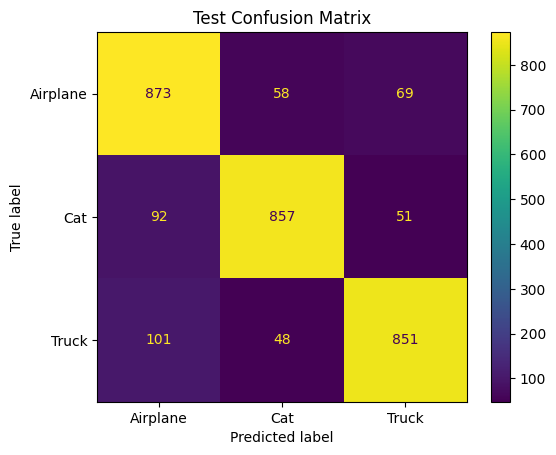

In [23]:
confusion_matrix = metrics.confusion_matrix(label_list,predictions)
plt.figure(figsize=(6,6))
plot_matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Airplane","Cat","Truck"])
plot_matrix.plot()
plt.title("Test Confusion Matrix")
plt.show()

In [24]:
mlp_model = nn.Sequential(
    nn.Linear(32*32*3,64),
    nn.ReLU(),
    nn.Linear(64, 3)
)

In [ ]:
import os
if not os.path.exists("mlp_model.pth"):
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    for j in range(15):
        mlp_model.train()
        epoch_loss_training = 0
        correct_classified = 0

        for i in train_dataloader:
            imgs, labels = i
            labels = labels.long()

            imgs = imgs.view(imgs.size(0), -1)

            optimizer.zero_grad()

            predictions = mlp_model(imgs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            epoch_loss_training += loss.item()

            temp, predicted_classes_for_batch = torch.max(predictions, 1)
            for k in range(len(predicted_classes_for_batch)):
                if predicted_classes_for_batch[k] == labels[k]:
                    correct_classified += 1

        train_loss.append(epoch_loss_training / len(train_dataloader))
        train_accuracy.append(correct_classified / len(train_dataloader.dataset))

        mlp_model.eval()
        epoch_loss_val=0
        correct_classified_val=0

        for i in val_dataloader:
            imgs, labels = i
            labels = labels.long()

            # Flatten images
            imgs = imgs.view(imgs.size(0), -1)

            predictions = mlp_model(imgs)
            loss = criterion(predictions, labels)
            epoch_loss_val += loss.item()

            temp, predicted_classes_for_batch = torch.max(predictions, 1)
            for k in range(len(predicted_classes_for_batch)):
                if predicted_classes_for_batch[k] == labels[k]:
                    correct_classified_val += 1

        val_loss.append(epoch_loss_val/len(val_dataloader))
        val_accuracy.append(correct_classified_val/len(val_dataloader.dataset))

        print(f"Epoch : {j+1}")
        print(f"Train Loss : {train_loss[-1]}")
        print(f"Train Accuracy : {train_accuracy[-1]}")
        print(f"Val Loss : {val_loss[-1]}")
        print(f"Val Accuracy : {val_accuracy[-1]}\n")


In [26]:
import os
if not os.path.exists("mlp_model.pth"):
    torch.save(mlp_model.state_dict(),"mlp_model.pth")

In [27]:
mlp_model.load_state_dict(torch.load("mlp_model.pth",weights_only=True))
mlp_model.eval()
predictions=[]
label_list=[]
pred_train=[]
pred_val=[]

for i in test_dataloader:
    imgs, labels=i
    imgs = imgs
    labels = labels.long()
    imgs = imgs.view(imgs.size(0), -1)
    
    predict = mlp_model(imgs)
    temp,predicted_classes = torch.max(predict, 1)
    
    predictions.extend(predicted_classes.numpy())
    label_list.extend(labels.numpy())

In [28]:
test_accuracy = accuracy_score(label_list,predictions)
test_f1_score = f1_score(label_list,predictions,average='weighted')

print(f"Test Accuracy : {test_accuracy}")
print(f"Test F1-Score : {test_f1_score}")

Test Accuracy : 0.7873333333333333
Test F1-Score : 0.7870755684770929


<Figure size 600x600 with 0 Axes>

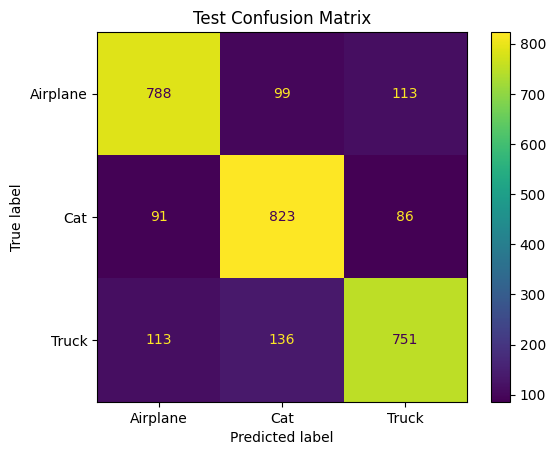

In [29]:
confusion_matrix = metrics.confusion_matrix(label_list,predictions)
plt.figure(figsize=(6,6))
plot_matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Airplane","Cat","Truck"])
plot_matrix.plot()
plt.title("Test Confusion Matrix")
plt.show()

In [30]:
for i in os.listdir(r".\\cifar-10-batches-py"):
    os.remove(f".\cifar-10-batches-py\{i}")
os.chmod(r".\\cifar-10-batches-py",0o777)
os.removedirs(r".\\cifar-10-batches-py")
os.remove(r".\\cifar-10-python.tar.gz")